In [1]:
import pandas as pd
import numpy as np
import datetime
import gtfstk as gt
import os, zipfile, requests, io, shutil, re
import tkinter as tk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tkinter import filedialog
from subprocess import Popen
%matplotlib inline
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42

In [2]:
def readOnlineFeed(url):
    r=requests.get(url)
    z=zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall('x')
    feed=gt.read_gtfs('x',dist_units='mi')
    shutil.rmtree('x')
    return feed
gtfs=readOnlineFeed(r"http://valleyregionaltransit.org/gtfs/VRT_Transit1.zip")

In [3]:
route_names=gtfs.routes['route_long_name']
route_namesArray=route_names.unique()
route_names={i:route_namesArray[i] for i in range(len(route_names.unique()))}
route_names.update([((len(route_names)+1),'All')])
route_names=route_names.values()

In [4]:
def button_otp_clicked():
    root.otp=filedialog.askdirectory(initialdir="/",title="Select OTP Detail Report")
def button_save_excel_clicked():
    root.save_excel_file=filedialog.asksaveasfilename(initialdir = "/",
                                                      title = "Select Excel file",
                                                      defaultextension='.xlsx',
                                                      filetypes = (("xlsx files","*.xlsx"),("all files","*.*")))
def button_save_plot_clicked():
    root.save_plot_file=filedialog.asksaveasfile(initialdir="/",
                                                 title="Select plot file",
                                                 defaultextension=".jpg",
                                                 filetypes=(("pdf files","*.pdf"),("jpeg files","*.jpg"),("all files","*.*")))
def close_window():
    root.route=tkvar.get()
    root.destroy()

root=tk.Tk()
root.title('On Time Performance by Time of Day')

tkvar=tk.StringVar(root)
tkvar.set('All')

label_otp=tk.Label(root,text="Select OTP Detail Report").grid(column=0,row=0)
button_gtfs=tk.Button(root,text="Browse",command=button_otp_clicked).grid(column=1,row=0)

label_out_excel=tk.Label(root,text="Save Excel Output").grid(column=0,row=1)
button_out=tk.Button(root,text="Browse",command=button_save_excel_clicked).grid(column=1,row=1)

label_out_plot=tk.Label(root,text="Save Plot").grid(column=0,row=2)
button_out_plot=tk.Button(root,text="Browse",command=button_save_plot_clicked).grid(column=1,row=2)

route_label=tk.Label(root,text="Pick a Route").grid(column=0,row=3)
route_choice=tk.OptionMenu(root,tkvar,*route_names).grid(column=1,row=3)

button_run=tk.Button(root,text='Run',width=25,command=close_window)
button_run.grid(column=0,row=4)
root.mainloop()

In [5]:
def appendOTPFiles(folder):
    df=pd.DataFrame()
    for i in os.listdir(folder):
        df=df.append(pd.read_csv(folder+"/"+i,parse_dates=['ScheduledStopTime']))
    return df

In [6]:
def ToDOTP(folder,route_long_name,gtfs=readOnlineFeed(r"http://valleyregionaltransit.org/gtfs/VRT_Transit1.zip"),save_file=None,route=None):
    feed=gtfs.stop_times.merge(gtfs.stops).merge(gtfs.trips).merge(gtfs.routes)
    if route_long_name!='All':
        feed=feed.loc[feed['route_long_name']==route_long_name]
    feed['Route Name']=feed['route_long_name']+" "+feed['route_long_name']
    df=appendOTPFiles(folder)
    if route_long_name!='All':
        df=df.loc[df['MasterRouteName']==route_long_name]
    df['Count']=1
    df['Early']=df['MinutesEarly']>0
    df['On Time']=(df['MinutesEarly']==0)&(df['MinutesLate']==0)
    df['Late']=df['MinutesLate']>0
    df['Hour']=df['ScheduledStopTime'].dt.hour
    outdf=pd.DataFrame(columns=['Early','On Time','Late','Count'])
    group_cols=['MasterRouteName','TripName','StopName','StopOrder','Hour']
    outdf['Early']=df.groupby(group_cols)['Early'].sum()
    outdf['On Time']=df.groupby(group_cols)['On Time'].sum()
    outdf['Late']=df.groupby(group_cols)['Late'].sum()
    outdf['Count']=df.groupby(group_cols)['Count'].sum()
    outdf.reset_index(inplace=True)
    outdf.sort_values(['MasterRouteName','TripName','StopOrder','StopName','Hour'],inplace=True)
    outdf=outdf.groupby(['MasterRouteName','StopName','Hour'],as_index=False,sort=False).sum()
    outdf['Early']=outdf['Early']/outdf['Count']
    outdf['On Time']=outdf['On Time']/outdf['Count']
    outdf['Late']=outdf['Late']/outdf['Count']
    outdf=outdf[['MasterRouteName','StopName','Hour','Early','On Time','Late']]
    outdf.rename({'MasterRouteName':'Route Name','StopName':'Stop Name'},axis=1,inplace=True)
    if save_file:
        outdf.to_excel(save_file,index=False)
    return outdf
ToDOTP(root.otp,root.route,save_file=root.save_excel_file)

,Route Name,Stop Name,Hour,Early,On Time,Late
0,BSU Express,CWI Main Campus,9,0.000000,0.825688,0.174312
1,BSU Express,9th & River SWC,9,0.000000,0.731343,0.268657
2,BSU Express,University & Joyce SEC,9,0.000000,0.715517,0.284483
3,BSU Express,Front & 3rd NEC,9,0.000000,0.636364,0.363636
4,BSU Express,Front & 9th NEC,9,0.015152,0.757576,0.227273
5,BSU Express,CWI Main Campus,10,0.000000,0.724138,0.275862
6,BSU Express,9th & River SWC,10,0.033898,0.847458,0.118644
7,BSU Express,University & Joyce SEC,10,0.000000,0.910891,0.089109
8,BSU Express,Front & 3rd NEC,10,0.000000,0.843137,0.156863
9,BSU Express,Front & 9th NEC,10,0.000000,0.771429,0.228571


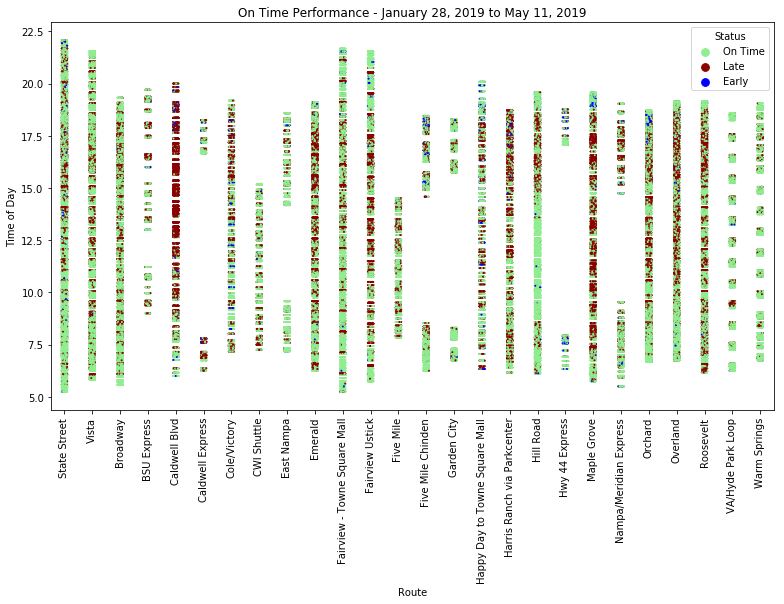

In [8]:
def plotToDOTP(folder,route_long_name,save_file=None):
    df=appendOTPFiles(folder)
    if route_long_name!='All':
        df=df.loc[df['MasterRouteName']==route_long_name]
    df['date']=df['ScheduledStopTime'].dt.date
    df['time']=df['ScheduledStopTime'].dt.time
    df['hour']=[r.hour for r in df.time]
    df['minutes']=[r.hour*60+r.minute for r in df.time]
    df['ToDdec']=df['minutes']/60
    df['Early']=df['MinutesEarly']>0
    df['On Time']=(df['MinutesEarly']==0)&(df['MinutesLate']==0)
    df['Late']=df['MinutesLate']>0
    df['Status']='On Time'
    df.loc[df.Early,'Status']='Early'
    df.loc[df.Late,'Status']='Late'
    f, ax=plt.subplots(figsize=(11,8.5))
    if route_long_name!='All':
        plot=sns.stripplot(x=df.StopName,y=df.ToDdec,size=2,hue=df.Status,palette={'Early':'blue','On Time':'lightgreen','Late':'darkred'},ax=ax)
    else:
        plot=sns.stripplot(x=df.MasterRouteName,y=df.ToDdec,size=2,hue=df.Status,palette={'Early':'blue','On Time':'lightgreen','Late':'darkred'},ax=ax)
    plt.xticks(rotation=90)
    plt.xlabel("Route")
    plt.ylabel("Time of Day")
    plt.title("On Time Performance - {} to {}".format(df.date.min().strftime("%B %d, %Y"),df.date.max().strftime("%B %d, %Y")))
    plt.tight_layout()
    if save_file:
        plot.figure.savefig(save_file)
#         plt.show()
    return plot
plot=plotToDOTP(root.otp,root.route,root.save_plot_file.name)

In [11]:
plt.show(plot)